# "Microsoft Studios:"
### _Should Microsoft Enter the Movie Business?_
##### __G. Haws & K. Hayes__
July 31, 2019
***
>*Sources:
TheMovieDB.org
Box Office Mojo
IMBD*

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
from Microsoft_Cleanup import *

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# Turn off scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# Import data
tn_budget = pd.read_csv('Data/Zipped_Data/tn.movie_budgets.csv.gz',\
                        compression='gzip')
bom_gross = pd.read_csv('Data/Zipped_Data/bom.movie_gross.csv.gz',\
                        compression='gzip')
imbd_basics = pd.read_csv('Data/Zipped_Data/imdb.title.basics.csv.gz',\
                          compression='gzip')
imbd_name = pd.read_csv('Data/Zipped_Data/imdb.name.basics.csv.gz',\
                        compression='gzip')
imbd_principals = pd.read_csv('Data/Zipped_Data/imdb.title.principals.csv.gz',\
                              compression='gzip')

### - Questions:
>#### - In order to maximize its investment, what scale of films should Microsoft produce?
>#### - What types of studios, producers, and directors should Microsoft seek out?

### - First Step: Data Cleaning
>#### - Cleaning the "tn_budget" file...

In [4]:
# Switch variables from string to float:
cast_to_float32(tn_budget, 'production_budget')
cast_to_float32(tn_budget, 'worldwide_gross')

In [5]:
# Create column for net profit (worldwide gross minus production budget):
net_columns(tn_budget, 'worldwide_gross', 'production_budget')

In [6]:
# Create column for ratio (net profit divided by production budget):
divide_columns(tn_budget, 'net', 'production_budget')

In [7]:
# Rename column 'movie' to 'title':
rename_col(tn_budget, 'movie', 'title')

In [8]:
# Remove whitespace, potential extra words, punctuation, and case from titles:
cleanup_text(tn_budget, 'title')

In [9]:
# Remove month and year from date:
convert_year(tn_budget, 'release_date')

In [10]:
# Drop redundant columns:
drop_cols(tn_budget, 'id', 'domestic_gross', 'release_date')

>#### Cleaning BOM_Gross file...

In [11]:
# Remove 'studio', 'domestic_gross', 'foreign_gross' column:
drop_cols(bom_gross, 'domestic_gross', 'foreign_gross')

In [12]:
# Set 'year' to string:
cast_to_str(bom_gross, 'year')

In [13]:
# Remove years, right whitespace, and superfluous verbiage from titles:
cleanup_text(bom_gross, 'title')

In [14]:
# Merge tn_budget and bom_gross:
merged_df = left_merge(tn_budget, bom_gross, 'title', 'year')

In [15]:
# Replace null studio values:
fill_na(merged_df, 'studio')

>#### Cleaning imbd_basics file...

In [16]:
# Create 'year' string column from 'start_year':
cast_to_str(imbd_basics, 'start_year')
rename_col(imbd_basics, 'start_year', 'year')

In [17]:
# Drop unused/confusing column:
drop_cols(imbd_basics, 'original_title')

In [18]:
# Rename column for easier merging:
rename_col(imbd_basics, 'primary_title', 'title')

In [19]:
# Remove years, right whitespace, and superfluous verbiage from titles:
cleanup_text(imbd_basics, 'title')

>##### and merge with previous version...

In [20]:
# Merge imbd_basics with merged datafile:
merged_df2 = left_merge(merged_df, imbd_basics, 'title', 'year')

In [21]:
# Cast year to integer:
cast_to_int(merged_df2, 'year')

In [22]:
# Throw out all films made before 2010:
cutoff_series_at(merged_df2, 'year', 2010)

In [23]:
# Now cast year back to string:
cast_to_str(merged_df2, 'year')

>#### Now, clean imbd_principals and imbd_name:

In [24]:
# Merge imbd_principals and imbd_name:
imbd_name_prin = pd.merge(imbd_principals, imbd_name,
                          on=["nconst"], how="left")

In [25]:
# Remove extraneous columns:
drop_cols(imbd_name_prin, 'ordering',
                                              'nconst', 'job',
                                              'characters', 'birth_year',
                                              'death_year',
                                              'primary_profession',
                                              'known_for_titles')

>##### Subset columns to populate directors:

In [26]:
# Create list of directors from imbd_name_prin:
directors = subset_series(imbd_name_prin, 'category', 'director')

In [27]:
# Merge list of directors with previous merged document:= 
merged_df3 = left_merge(merged_df2, directors, 'tconst')

In [28]:
# Remove extra columns:
drop_cols(merged_df3, 'category', 'runtime_minutes')

In [29]:
#rename primary_name to, "director":
rename_col(merged_df3, 'primary_name', 'director')

In [30]:
# Fill in null director values:
fill_na(merged_df3, 'director')

>##### ... and do the same for producers:

In [31]:
# Now, create list of producers from imbd_name_prin:
producers = subset_series(imbd_name_prin, 'category', 'producer')

In [32]:
# Rename column primary_name to, "producer":
rename_col(producers, 'primary_name', 'producer')

/home/george/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [33]:
# Drop column 'category':
drop_cols(producers, 'category')

/home/george/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# Merge list of producers with merged document:
merged_df4 = pd.merge(merged_df3, producers, on=["tconst"], how="left")

In [35]:
# Fill null producer values:
fill_na(merged_df4, 'producer')

>##### And now some final steps:

In [36]:
# Remove duplicate titles:
remove_duplicates(merged_df4, 'title')

In [37]:
# Finally, drop the extra column:
drop_cols(merged_df4, 'tconst')

In [38]:
# And rename:
md_clean = merged_df4

### Okay, now that we're done cleaning...
### Let's explore:

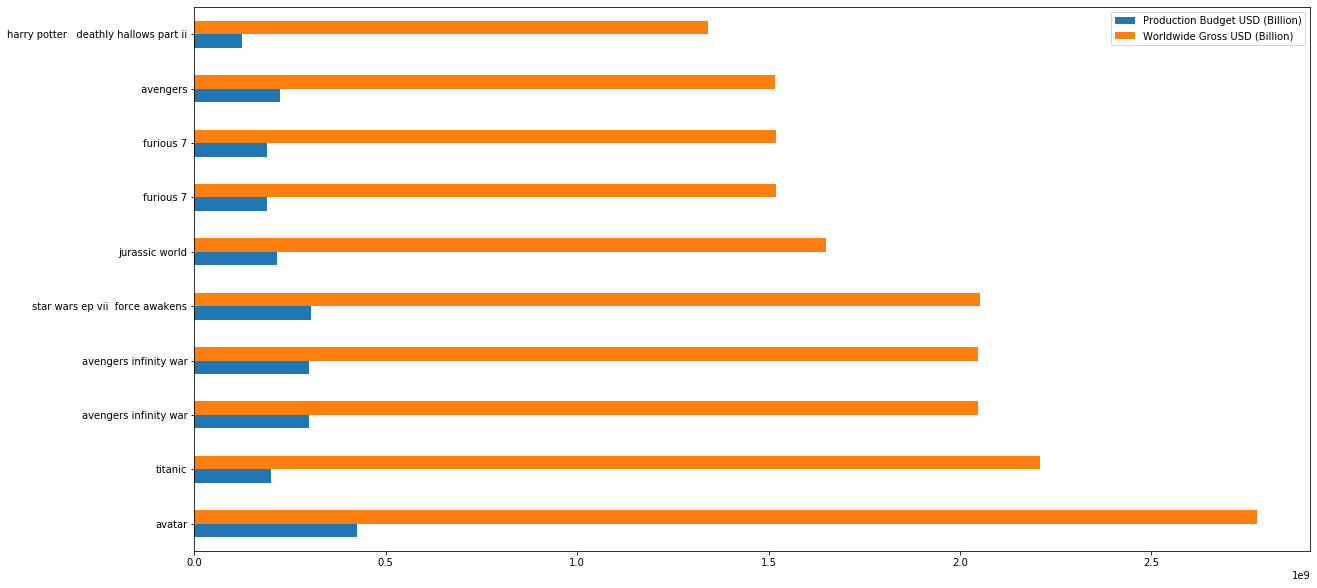

In [39]:
# Create earnings/cost graph for films with top ROI
top_net = md_clean.sort_values(by=['net'], ascending=False)[:10]

index = list(top_net['title'])
production_budget = list(top_net['production_budget'])
worldwide_gross = list(top_net['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (Billion)':
                   production_budget,
                   'Worldwide Gross USD (Billion)':
                   worldwide_gross}, index=index)
ax = df.plot.barh(figsize=(20, 10), rot=0)

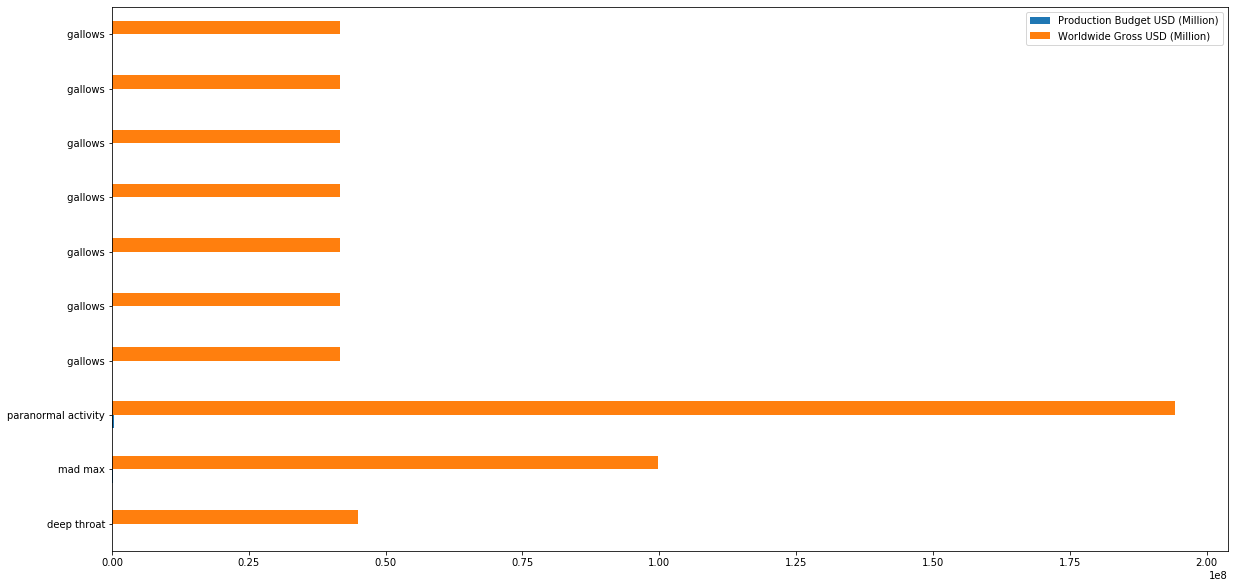

In [40]:
# Create earnings/cost graph for films with top ROI
top_ratio = md_clean.sort_values(by=['ratio'], ascending=False)[:10]

index = list(top_ratio['title'])
production_budget = list(top_ratio['production_budget'])
worldwide_gross = list(top_ratio['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (Million)': production_budget,
                   'Worldwide Gross USD (Million)': worldwide_gross},
                  index=index)
ax = df.plot.barh(figsize=(20, 10), rot=0)

In [41]:
# Create a list of 20 studios with the top ratio means
studio_ratio_mean = (md_clean.groupby
                     (['studio']).ratio.mean().
                     sort_values(ascending=False)[:20])

In [42]:
# Create a list of 20 directors with the top ratio means
director_ratio_mean = (md_clean.groupby
                       (['director']).ratio.mean().
                       sort_values(ascending=False)[0:20])

In [43]:
# Create a list of 19 directors with the top ROI means,
# with top value removed
director_ratio_mean_19 = (md_clean.groupby
                          (['director']).ratio.mean().
                          sort_values(ascending=False)[1:20])

In [44]:
# Create a list of 20 producers with the top ROI means
producer_ratio_mean = (md_clean.groupby
                       (['producer']).ratio.mean()
                       .sort_values(ascending=False)[:20])

In [45]:
# Provides a count for the number of films made by
# each director with a top-20 ROI
director_ROI_count = (md_clean.groupby
                      ('director')['ratio', 'title'].agg
                      ({'ratio': 'mean', 'title': 'nunique'})
                      .sort_values
                      (by='ratio', ascending=False))[0:20].reset_index()

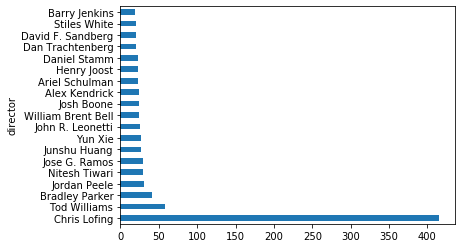

In [46]:
#Creates a graph of the 2-20 directors with the best ROI
director_ratio_mean_19.plot(kind='barh')

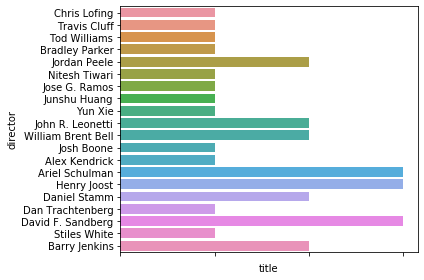

In [47]:
# Make a barplot - top 20 directors by ROI - Count
top_20_directors_ROI_count = (md_clean.groupby
                              ('director')['ratio', 'title']
                              .agg({'ratio':
                                    'mean', 'title': 'nunique'})
                              .sort_values
                              (by='ratio',
                               ascending=False))[0:20].reset_index()
ax = sns.barplot(x=top_20_directors_ROI_count['title'],
                 y=top_20_directors_ROI_count['director'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 1
plt.tight_layout()
plt.show()